<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/Turtle's_Way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pykrx finance-datareader

In [3]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt


성과 지표:
초기 자산: 100,000,000 원
최종 자산: 314,029,595 원
성장률: 214.03%
누적 수익률: 214.03%
최대 손실(MDD): 53.03%

마지막 10일 데이터:
            Close  True_Range       N  Position_Size  Buy_Signal  Exit_Signal  \
Date                                                                            
2024-12-16  33000      1050.0  1187.5       0.003368       False        False   
2024-12-17  32950       700.0  1185.0       0.003376       False        False   
2024-12-18  33500       700.0  1160.0       0.003448       False        False   
2024-12-19  32850      1050.0  1170.0       0.003419       False        False   
2024-12-20  32800       750.0  1165.0       0.003433       False        False   
2024-12-23  33800      1000.0  1185.0       0.003376       False        False   
2024-12-24  33800       950.0  1200.0       0.003333       False        False   
2024-12-26  33550       800.0  1187.5       0.003368       False        False   
2024-12-27  32100      1900.0  1212.5       0.003299       False         True 

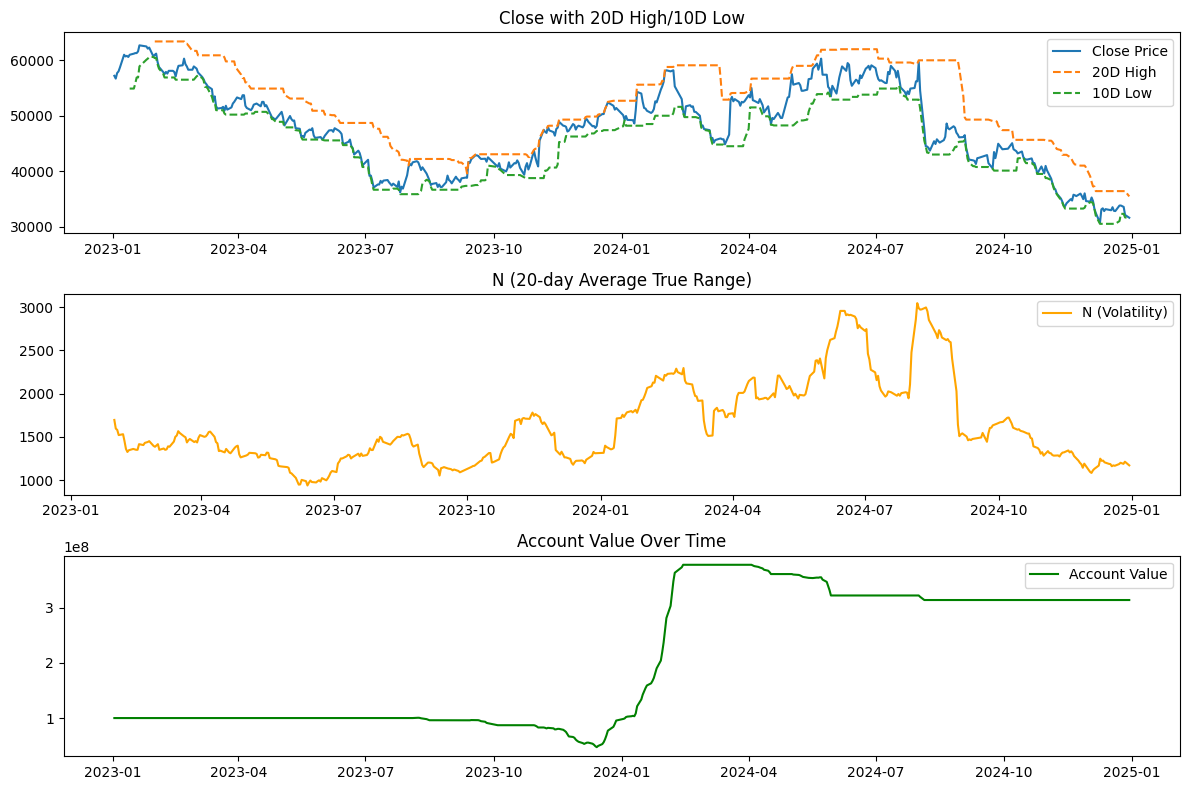

In [14]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 종목/지수 데이터 가져오기
ticker = '000210'
data = fdr.DataReader(ticker, start='2023-01-01', end='2024-12-31')
data = data[['High', 'Low', 'Close']].copy()

# 2. True Range 및 N 계산
data['Prev_Close'] = data['Close'].shift(1)
data['TR1'] = data['High'] - data['Low']
data['TR2'] = abs(data['High'] - data['Prev_Close'])
data['TR3'] = abs(data['Prev_Close'] - data['Low'])
data['True_Range'] = data[['TR1', 'TR2', 'TR3']].max(axis=1)
data['N'] = data['True_Range'].rolling(window=20).mean()

# 3. 터틀 트레이딩 규칙
data['20D_High'] = data['High'].rolling(window=20).max()
data['10D_Low'] = data['Low'].rolling(window=10).min()
data['Buy_Signal'] = data['Close'] > data['20D_High'].shift(1)
data['Exit_Signal'] = data['Close'] < data['10D_Low'].shift(1)

# 4. 포지션 사이징 및 계좌 관리
account_size = 100000000  # 초기 자산: 1억 원
risk_ratio = 0.01         # 리스크 비율: 1%
contract_unit = 250000    # KOSPI 200 선물: 1포인트 = 25만 원

# 포지션 크기 = (계좌 자산 × 리스크 비율) / (N × 계약 단위 가치)
data['Position_Size'] = (account_size * risk_ratio) / (data['N'] * contract_unit)

# 5. 백테스트 (변동성 돌파 전략)
position = 0  # 현재 포지션 (계약 수)
entry_price = 0  # 진입 가격
pyramid_count = 0  # 피라미딩 횟수
account_values = [account_size]  # 계좌 자산 추이
pnl_list = []  # 일일 손익

for i in range(1, len(data)):
    # 초기화
    daily_pnl = 0

    # 진입 조건: 20일 고가 돌파
    if data['Buy_Signal'].iloc[i] and position == 0:
        position = data['Position_Size'].iloc[i]
        entry_price = data['Close'].iloc[i]
        pyramid_count = 1  # 최초 진입
        # print(f"Buy at {data.index[i]}: {position:.2f} contracts at {entry_price:.2f}")

    # 피라미딩: 가격이 0.5N 상승 시 추가 매수 (최대 4회)
    elif position > 0 and pyramid_count < 4:
        price_change = data['Close'].iloc[i] - entry_price
        if price_change > 0.5 * data['N'].iloc[i]:
            additional_position = data['Position_Size'].iloc[i]
            position += additional_position
            entry_price = data['Close'].iloc[i]  # 평균 진입 가격 갱신
            pyramid_count += 1
            # print(f"Pyramid at {data.index[i]}: Added {additional_position:.2f} contracts, Total: {position:.2f}")

    # 청산 조건: 10일 저가 하락
    if position > 0 and data['Exit_Signal'].iloc[i]:
        profit = (data['Close'].iloc[i] - entry_price) * position * contract_unit
        daily_pnl = profit
        position = 0
        pyramid_count = 0
        # print(f"Exit at {data.index[i]}: Profit {profit:.2f}")

    # 일일 손익 계산 (포지션 보유 시 미실현 손익)
    if position > 0:
        daily_pnl = (data['Close'].iloc[i] - entry_price) * position * contract_unit

    # 계좌 자산 갱신
    account_size += daily_pnl
    account_values.append(account_size)
    pnl_list.append(daily_pnl)

# 계좌 자산을 데이터프레임에 추가
data['Account_Value'] = account_values[:len(data)]
data['Daily_PnL'] = pnl_list + [0]  # 마지막 날은 0으로 패딩

# 6. 성과 지표 계산
initial_account = 100000000
final_account = data['Account_Value'].iloc[-1]
growth_rate = (final_account - initial_account) / initial_account * 100
returns = data['Account_Value'].pct_change().dropna()
cumulative_return = (data['Account_Value'].iloc[-1] / initial_account - 1) * 100
max_drawdown = ((data['Account_Value'].cummax() - data['Account_Value']) / data['Account_Value'].cummax()).max() * 100

print("\n성과 지표:")
print(f"초기 자산: {initial_account:,.0f} 원")
print(f"최종 자산: {final_account:,.0f} 원")
print(f"성장률: {growth_rate:.2f}%")
print(f"누적 수익률: {cumulative_return:.2f}%")
print(f"최대 손실(MDD): {max_drawdown:.2f}%")

# 7. 결과 출력 (마지막 10일)
print("\n마지막 10일 데이터:")
print(data[['Close', 'True_Range', 'N', 'Position_Size', 'Buy_Signal', 'Exit_Signal', 'Account_Value']].tail(10))

# 8. 시각화
plt.figure(figsize=(12, 8))

# 종가와 N
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['20D_High'], label='20D High', linestyle='--')
plt.plot(data.index, data['10D_Low'], label='10D Low', linestyle='--')
plt.title('Close with 20D High/10D Low')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data.index, data['N'], label='N (Volatility)', color='orange')
plt.title('N (20-day Average True Range)')
plt.legend()

# 계좌 자산 추이
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Account_Value'], label='Account Value', color='green')
plt.title('Account Value Over Time')
plt.legend()

plt.tight_layout()
plt.show()